In [1]:
%load_ext autoreload
%autoreload 2

In [104]:
from queries import start_elastic_search, index_documents
from trec_files import make_trec_run
from trec_files import read_eval_files
from evaluation import trec_eval
from evaluation import mean_average_precision
from evaluation import print_trec_eval
import elasticsearch
import elasticsearch.helpers
import json
from elasticsearch import Elasticsearch
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from elasticsearch_dsl import Q
from elasticsearch_dsl import Search
import numpy as np
import matplotlib.pyplot as plt

print("done")

done


In [3]:
# Connect to the ElasticSearch server
es = elasticsearch.Elasticsearch(host='localhost')  # in case you use Docker, the host is 'elasticsearch'

# Index the collection into the index called 'genomics'
body = {} # no indexing options (leave default)
index_documents(es, 'data01/FIR-s05-medline.json', 'genomics-base', body)

/home/ut-student/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


(263080, [])

In [84]:
# connect to ES server             
es = elasticsearch.Elasticsearch('localhost')

# Write the results of the queries contained in the topic file `'data/training-queries-simple.txt'` 
# to the run file `'baseline.run'`, and name this test as `test01`
# make_trec_run(es, 'data01/FIR-s05-training-queries-simple.txt', 'baseline.run', "genomics-base", run_name='no_pseudo_01')

def pseudo_IR(i, j):
    make_trec_run(es, 'data01/FIR-s05-training-queries-simple.txt', 'baseline.run', "genomics-base", run_name='pseudo_01', pseudo_relevance=True, k_docs=i, terms_frac=j)

    results = trec_eval('data01/FIR-s05-training-qrels.txt', 'baseline.run')
    mean_average_precision = results[-1][1]
    
    return mean_average_precision

print("done")

done


In [85]:
results = []
for i in range(2, 21, 2):
    for j in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        # Call the IR function and append the result to the 'results' array
        result = pseudo_IR(i, j)
        results.append(result)
        print(result)

# Print or use the 'results' array as needed
print(results)

0.12260028173839875
0.11286940341153565
0.1151222799693964
0.10555120583974259
0.10219650682531334
0.10093987820966484
0.09884595296838822
0.10086820265200559
0.09383488074114262
0.09542310091614904
0.11918139415729793
0.11137471629078376
0.10024515729189468
0.09646836074477882
0.09734682767735568
0.0847020370767162
0.08593143588990175
0.08567330794844451
0.08857943494179243
0.08272829774531014
0.12172727443486515
0.0989722219708076
0.09106453560541206
0.09733334882390854
0.10426592161630671
0.10463165629114933
0.09134449861604155
0.09658737093829003
0.0972359860249044
0.09044176537954164
0.11464902062113619
0.09309767191318732
0.10367174909843174
0.10572406635307038
0.09117318122420151
0.09303468584351801
0.09154379271742995
0.0882064627666523
0.08656420458400865
0.07781556938801615
0.10840191309845199
0.08901433310985561
0.10100958472441227
0.08833819972088723
0.08955193955676148
0.08800209015029986
0.09031384178318769
0.09198037170593754
0.08846918039003496
0.08781605615877378
0.104

In [102]:
# In case results accidentely gets scrapped
backup_results = results

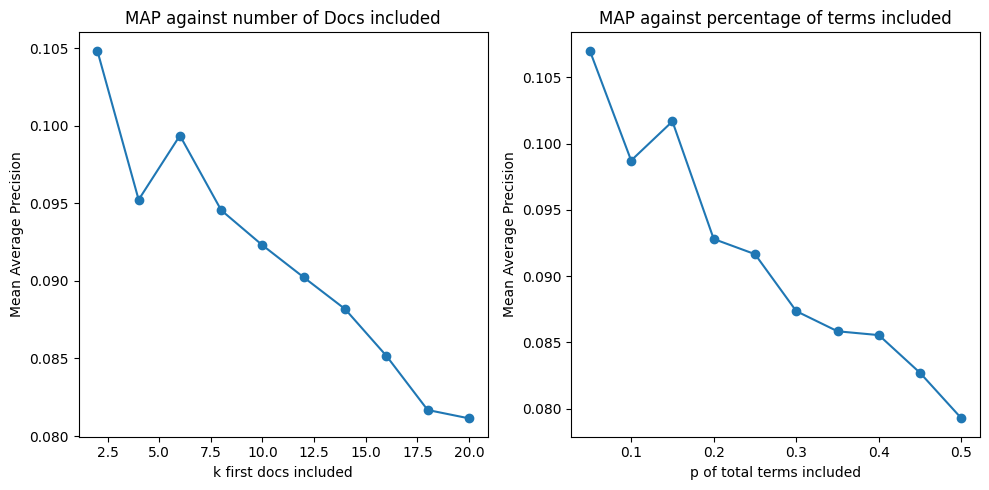

In [106]:
results_array = np.array(results).reshape((len(range(2, 21, 2)), len(np.arange(0.05, 0.55, 0.05))))

# Plot mean_average_precision as a function of i
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 21, 2), results_array.mean(axis=1), marker='o')
plt.title('MAP against number of Docs included')
plt.xlabel('k first docs included')
plt.ylabel('Mean Average Precision')

# Plot mean_average_precision as a function of j
plt.subplot(1, 2, 2)
plt.plot(np.arange(0.05, 0.55, 0.05), results_array.mean(axis=0), marker='o')
plt.title('MAP against percentage of terms included')
plt.xlabel('part of total terms included')
plt.ylabel('Mean Average Precision')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

# Pseudo-Feedback Relevance

## Evaluate